In [ ]:
import cv2
import os
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns
from sklearn.metrics import hinge_loss

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#PAth to the JAFFE And CK Dataset available
dir_JAffE = "/content/drive/My Drive/JAFFE-[70,30]/JAFFE-[70,30]/train"
dir_CK = "/content/drive/My Drive/CK_dataset/CK_dataset/train"

#Function to check count of each label
def find_Label_Count(directory):
    labels_counts = {}
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            labels_counts[label] = len(os.listdir(label_path))
    return labels_counts

JAFFE_count = find_Label_Count(dir_JAffE)
CK_count = find_Label_Count(dir_CK)
# Display the counts
print("JAFFE DATASET LABEL COUNT \n" )
for label, count in JAFFE_count.items():

    print( f"Label: {label}, Count: {count}")
print("\n")
print("CK DATASET LABEL COUNT\n")
for label, count in CK_count.items():

    print( f"Label: {label}, Count: {count}")

JAFFE DATASET LABEL COUNT 

Label: Surprise, Count: 21
Label: Sad, Count: 22
Label: Angry, Count: 20
Label: Fear, Count: 22
Label: Happy, Count: 22
Label: Neutral, Count: 21


CK DATASET LABEL COUNT

Label: neutral, Count: 86
Label: surprise, Count: 83
Label: happy, Count: 75
Label: anger, Count: 40
Label: fear, Count: 16
Label: sadness, Count: 41


In [ ]:
# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier("/content/drive/My Drive/haarcascade_frontalface_default.xml")

# Function to load images, detect faces, and extract cropped face regions
def load_and_detect_faces(folder_path):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w]
                        images.append(face_region)
                        labels.append(label)
    return images, labels


In [ ]:
#Function for extracting hog features
def extract_hog_features(images):
    hog_features = []
    for img in images:
        img = cv2.resize(img, (64, 64))
        #Compute  HOG Features
        hog_feat = hog(img, orientations=8, pixels_per_cell= (8, 8), cells_per_block=(2,2), block_norm='L2-Hys', visualize=False)
        hog_features.append(hog_feat)
    return np.array(hog_features)

In [ ]:
#Augmenting and flipping images horizontally

def augment_with_flipped_images(images, labels, flip_mode='horizontal'):

    flipped_images = []
    flipped_labels = []

    for image, label in zip(images, labels):
        if flip_mode == 'horizontal':
            flipped_image = np.flip(image, axis=1)  # Horizontal flip
        elif flip_mode == 'vertical':
            flipped_image = np.flip(image, axis=0)  # Vertical flip
        else:
            raise ValueError("Invalid flip_mode. Use 'horizontal' or 'vertical'.")

        flipped_images.append(flipped_image)
        flipped_labels.append(label)

    # Combine original and flipped images and labels
    augmented_images = images + flipped_images
    augmented_labels = labels + flipped_labels

    return augmented_images, augmented_labels

In [ ]:
from sklearn.preprocessing import StandardScaler

# Set paths for training and testing folders
JAFFE_train_folder_path = "/content/drive/My Drive/JAFFE-[70,30]/JAFFE-[70,30]/train"
JAFFE_test_folder_path = "/content/drive/My Drive/JAFFE-[70,30]/JAFFE-[70,30]/test"

CK_train_folder_path = "/content/drive/My Drive/CK_dataset/CK_dataset/train"
CK_test_folder_path = "/content/drive/My Drive/CK_dataset/CK_dataset/test"


#CK DATASET
# Load, detect faces, and extract features for training data
CK_X_train_faces, CK_y_train = load_and_detect_faces(CK_train_folder_path)
print("Class distribution Training Dataset CK:", Counter(CK_y_train))
CK_X_train_faces, CK_y_train = augment_with_flipped_images(CK_X_train_faces, CK_y_train, flip_mode="horizontal")
CK_X_train_features = extract_hog_features(CK_X_train_faces)

# Load, detect faces, and extract features for testing data
CK_X_test_faces, CK_y_test = load_and_detect_faces(CK_test_folder_path)
print("Class distribution Testing Dataset CK:", Counter(CK_y_test))

CK_X_test_faces, CK_y_test = augment_with_flipped_images(CK_X_test_faces, CK_y_test, flip_mode="horizontal")

CK_X_test_features = extract_hog_features(CK_X_test_faces)

#JAFFE DATASET
# Load, detect faces, and extract features for training data
JAFFE_X_train_faces, JAFFE_y_train = load_and_detect_faces(JAFFE_train_folder_path)
print("Class distribution Training Dataset JAFFE:", Counter(JAFFE_y_train))

JAFFE_X_train_faces, JAFFE_y_train = augment_with_flipped_images(JAFFE_X_train_faces, JAFFE_y_train, flip_mode="horizontal")
JAFFE_X_train_features = extract_hog_features(JAFFE_X_train_faces)

# Load, detect faces, and ex2act features for testing data
JAFFE_X_test_faces, JAFFE_y_test = load_and_detect_faces(JAFFE_test_folder_path)
print("Class distribution Testing Dataset JAFFE:", Counter(CK_y_train))

JAFFE_X_test_faces, JAFFE_y_test = augment_with_flipped_images(JAFFE_X_test_faces, JAFFE_y_test, flip_mode="horizontal")
JAFFE_X_test_features = extract_hog_features(JAFFE_X_test_faces)

print("Class distribution after augmentation CK Dataset:", Counter(CK_y_train))
print("Class distribution after augmentation JAFFE Dataset:", Counter(JAFFE_y_train))


#Oversampling the labels with less number of samples to match the models
smote = SMOTE(random_state=42)
CK_X_resampled, CK_y_resampled = smote.fit_resample(CK_X_train_features, CK_y_train)

JAFFE_X_resampled, JAFFE_y_resampled = smote.fit_resample(JAFFE_X_train_features, JAFFE_y_train)

print("Resampled class distribution CK DATASET:", Counter(CK_y_resampled))
print("Resampled class distribution JAFFE DATASET:", Counter(JAFFE_y_resampled))




Class distribution Training Dataset CK: Counter({'neutral': 86, 'surprise': 82, 'happy': 75, 'sadness': 41, 'anger': 40, 'fear': 16})
Class distribution Testing Dataset CK: Counter({'neutral': 36, 'surprise': 35, 'happy': 32, 'anger': 18, 'sadness': 17, 'fear': 7})
Class distribution Training Dataset JAFFE: Counter({'Sad': 22, 'Fear': 22, 'Happy': 22, 'Surprise': 21, 'Neutral': 21, 'Angry': 20})
Class distribution Testing Dataset JAFFE: Counter({'neutral': 172, 'surprise': 164, 'happy': 150, 'sadness': 82, 'anger': 80, 'fear': 32})
Class distribution after augmentation CK Dataset: Counter({'neutral': 172, 'surprise': 164, 'happy': 150, 'sadness': 82, 'anger': 80, 'fear': 32})
Class distribution after augmentation JAFFE Dataset: Counter({'Sad': 44, 'Fear': 44, 'Happy': 44, 'Surprise': 42, 'Neutral': 42, 'Angry': 40})
Resampled class distribution CK DATASET: Counter({'neutral': 172, 'surprise': 172, 'happy': 172, 'anger': 172, 'fear': 172, 'sadness': 172})
Resampled class distribution JA

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validatio

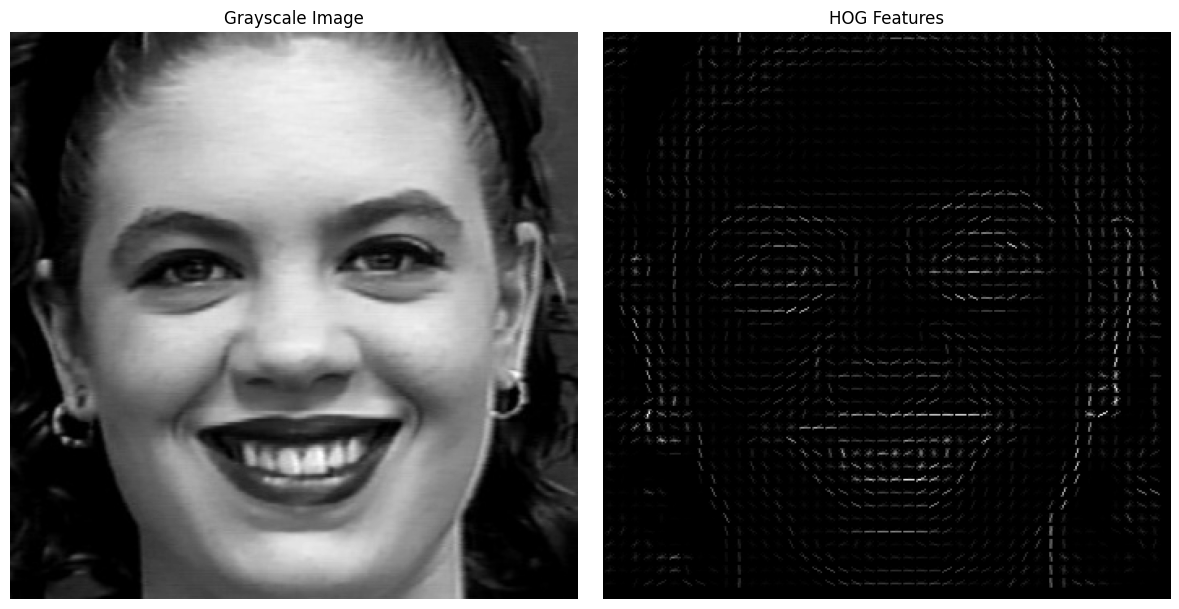

In [ ]:
from skimage.feature import hog
from skimage import io, color

def visualize_hog_features(image_path):

    #Load the image
    image = io.imread(image_path)

    #Convert the image to grayscale if it's in RGB
    if len(image.shape) == 3:  # Check if the image has 3 channels
            image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)


    #Compute HOG features and the visualization
    hog_features, hog_image = hog(image, pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        block_norm='L2-Hys'
    )

    # Display the original and HOG feature visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Grayscale Image")
    axes[0].axis('off')

    axes[1].imshow(hog_image, cmap='gray')
    axes[1].set_title("HOG Features")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_path = "/content/drive/My Drive/CK_dataset/CK_dataset/test/happy/0.jpg"  # Replace with the path to one of your images
visualize_hog_features(image_path)


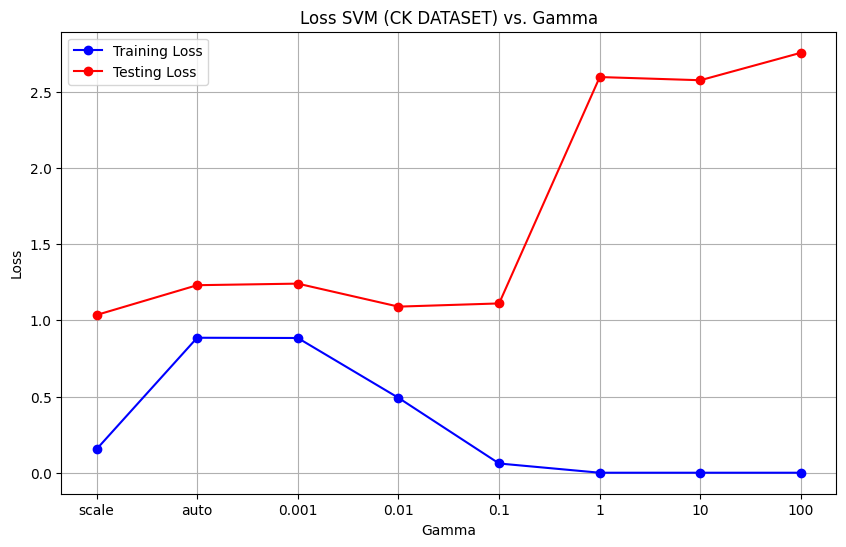

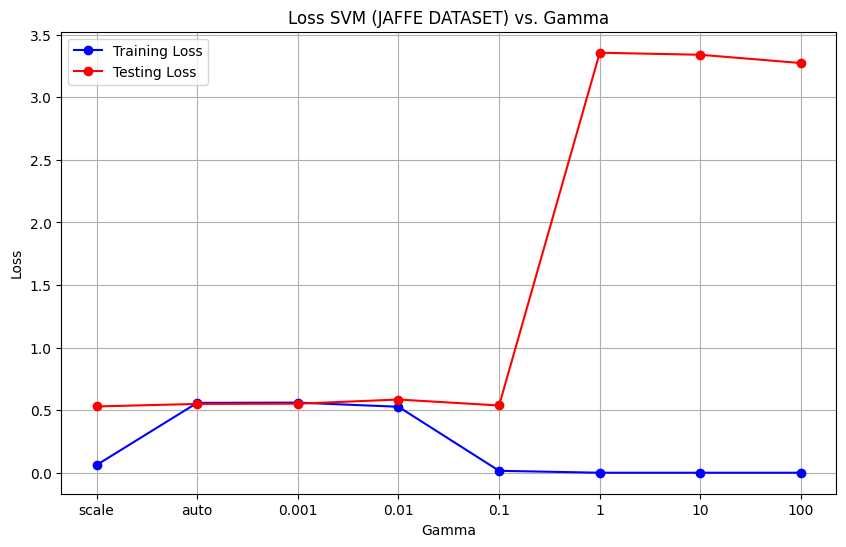

In [ ]:

def loss_graph_cal(data_X, data_Y, test_X,test_Y, dataset_name):
 #Define gamma values
  gamma_values = ['scale', 'auto', 0.001 ,0.01, 0.1, 1, 10, 100]
  train_loss_values = []
  test_loss_values = []


#Train an SVM model with different gamma values and compute loss
  for gamma in gamma_values:
    svm_classifier3 = SVC(kernel='rbf',  C=1, gamma=gamma)
    svm_classifier3.fit(data_X, data_Y)

    #Hinge loss used so decision function used.
    #Training loss
    decision_function =  svm_classifier3.decision_function(data_X)
    train_loss = hinge_loss(data_Y, decision_function)
    train_loss_values.append(train_loss)
    #Testing loss
    decision_function =  svm_classifier3.decision_function(test_X)
    test_loss = hinge_loss(test_Y, decision_function)
    test_loss_values.append(test_loss)

  plt.figure(figsize=(10, 6))
  plt.plot(gamma_values, train_loss_values, marker='o', label='Training Loss', color='blue')
  plt.plot(gamma_values, test_loss_values, marker='o', label='Testing Loss', color ='red')
  plt.xlabel('Gamma')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Loss SVM (' + dataset_name + ') vs. Gamma')
  plt.grid(True)
  plt.show()

  #MEthod was initally repeated for c and kernels but realized kernels and C was optimal

loss_graph_cal(CK_X_resampled, CK_y_resampled, CK_X_test_features,CK_y_test, "CK DATASET")
loss_graph_cal(JAFFE_X_resampled, JAFFE_y_resampled, JAFFE_X_test_features,JAFFE_y_test, "JAFFE DATASET")



In [ ]:
svm_classifier_CK = SVC(kernel='rbf',  C=1, class_weight='balanced',gamma=0.01)
#svm_classifier_CK.fit(CK_X_train_, CK_y_train) Testing without SMOTE
svm_classifier_CK.fit(CK_X_resampled, CK_y_resampled)


SVC(C=1, class_weight='balanced', gamma=0.01)

In [ ]:
svm_classifier_JAFFE = SVC(kernel='rbf', C=1, class_weight='balanced', gamma=0.01)
#svm_classifier_JAFFE.fit(JAFFE_X_train_features, JAFFE_y_train) Testing without SMOTE
svm_classifier_JAFFE.fit(JAFFE_X_resampled, JAFFE_y_resampled)

SVC(C=1, class_weight='balanced', gamma=0.01)

Accuracy CK DATASET: 65.86%
Accuracy JAFFE DATASET: 80.91%
Confusion Matrix CK DATASET:
[[20  3  0 10  3  0]
 [ 1  1  0  4  8  0]
 [ 1  0 50 11  0  2]
 [ 3  2  4 57  4  2]
 [ 2  0  0 16 16  0]
 [ 0  2  0 19  2 47]]
Confusion Matrix JAFFE DATASET:
[[12  0  0  0  6  0]
 [ 0 20  0  0  0  0]
 [ 0  6 12  0  0  0]
 [ 0  1  0 17  0  0]
 [ 0  0  0  0 18  0]
 [ 0  8  0  0  0 10]]


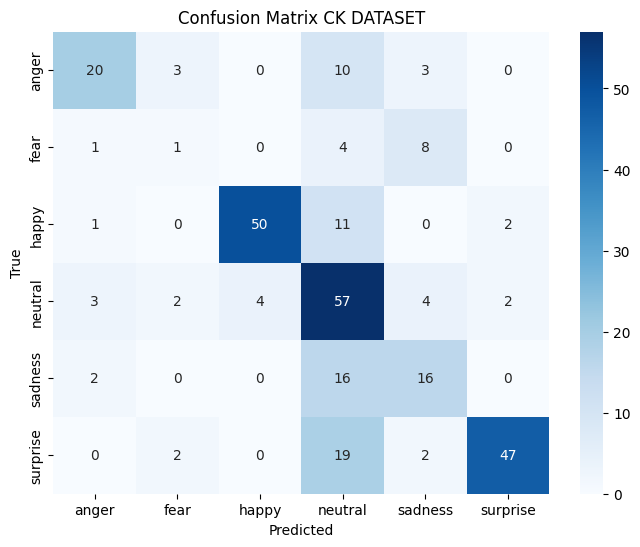

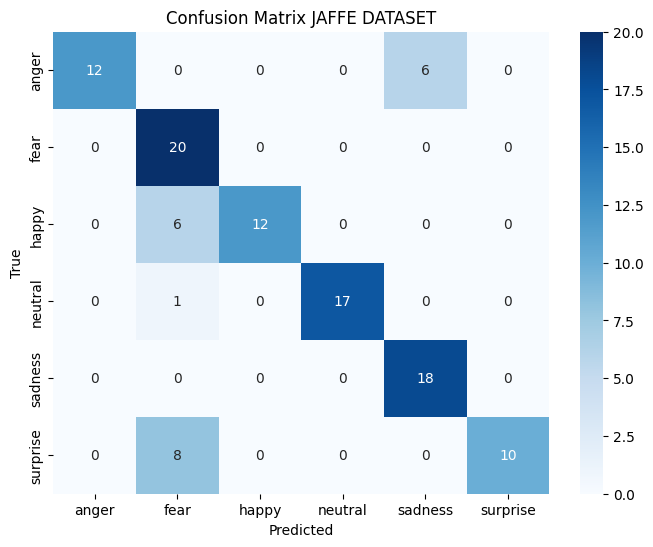

In [ ]:
CK_y_pred = svm_classifier_CK.predict(CK_X_test_features)
JAFFE_y_pred = svm_classifier_JAFFE.predict(JAFFE_X_test_features)


# Calculate accuracy
accuracy_CK = accuracy_score(CK_y_test, CK_y_pred)

accuracy_JAFFE = accuracy_score(JAFFE_y_test, JAFFE_y_pred)

precision_CK = precision_score(CK_y_test, CK_y_pred, average='macro')
precision_JAFFE = precision_score(JAFFE_y_test, JAFFE_y_pred, average='macro')


print(f"Accuracy CK DATASET: {accuracy_CK * 100:.2f}%")

print(f"Accuracy JAFFE DATASET: {accuracy_JAFFE * 100:.2f}%")

# Display Confusion Matrix
conf_matrix_CK = confusion_matrix(CK_y_test, CK_y_pred)
conf_matrix_JAFFE = confusion_matrix(JAFFE_y_test, JAFFE_y_pred)

print("Confusion Matrix CK DATASET:")
print(conf_matrix_CK)

print("Confusion Matrix JAFFE DATASET:")
print(conf_matrix_JAFFE)
#Visualizing the confusion matrix for better understanding

def plot_confusion_Matrix(conf_matrix, label):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.union1d(CK_y_test, CK_y_pred),
            yticklabels=np.union1d(CK_y_test, CK_y_pred))
    plt.title('Confusion Matrix ' + label)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_Matrix(conf_matrix_CK, "CK DATASET")
plot_confusion_Matrix(conf_matrix_JAFFE, "JAFFE DATASET")

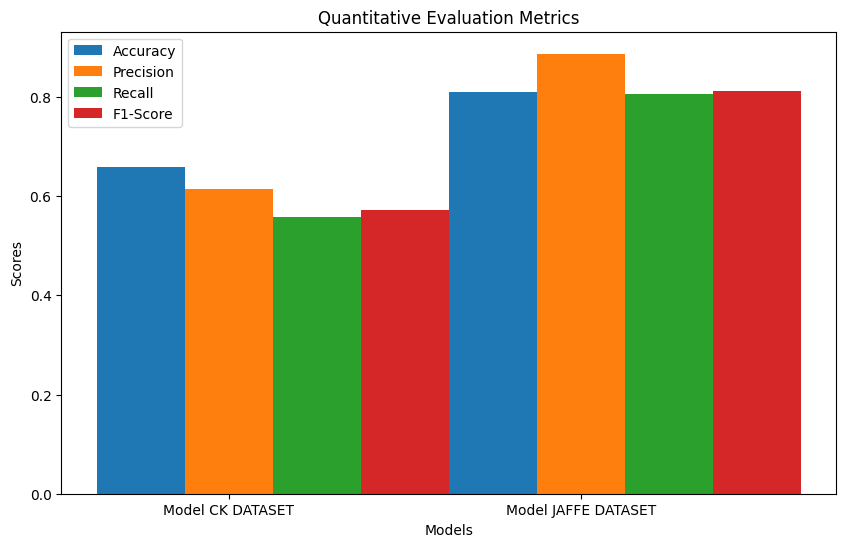

In [ ]:

# Bar plot for performance metrics comparison
import matplotlib.pyplot as plt

models = ['Model CK DATASET', 'Model JAFFE DATASET']
metrics = {
    'Accuracy': [accuracy_CK, accuracy_JAFFE],
    'Precision': [precision_score(CK_y_test, CK_y_pred, average='macro'), precision_score(JAFFE_y_test, JAFFE_y_pred, average='macro')],
    'Recall': [recall_score(CK_y_test, CK_y_pred,average='macro'), recall_score(JAFFE_y_test, JAFFE_y_pred,average='macro')],
    'F1-Score': [f1_score(CK_y_test, CK_y_pred,average='macro'), f1_score(JAFFE_y_test, JAFFE_y_pred,average='macro')]
}

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, (metric, values) in enumerate(metrics.items()):
    ax.bar(x + (i - 1) * width, values, width, label=metric)

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Quantitative Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()

In [ ]:
# Generate and print classification report for CK dataset
print("Classification Report for CK Dataset:")
print(classification_report(CK_y_test, CK_y_pred))

# Generate and print classification report for JAFFE dataset
print("\nClassification Report for JAFFE Dataset:")
print(classification_report(JAFFE_y_test, JAFFE_y_pred))

Classification Report for CK Dataset:
              precision    recall  f1-score   support

       anger       0.74      0.56      0.63        36
        fear       0.12      0.07      0.09        14
       happy       0.93      0.78      0.85        64
     neutral       0.49      0.79      0.60        72
     sadness       0.48      0.47      0.48        34
    surprise       0.92      0.67      0.78        70

    accuracy                           0.66       290
   macro avg       0.61      0.56      0.57       290
weighted avg       0.70      0.66      0.66       290


Classification Report for JAFFE Dataset:
              precision    recall  f1-score   support

       Angry       1.00      0.67      0.80        18
        Fear       0.57      1.00      0.73        20
       Happy       1.00      0.67      0.80        18
     Neutral       1.00      0.94      0.97        18
         Sad       0.75      1.00      0.86        18
    Surprise       1.00      0.56      0.71        1

<ipython-input-69-984eea8f78a0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotions, y=accuracy_scores, palette="viridis")


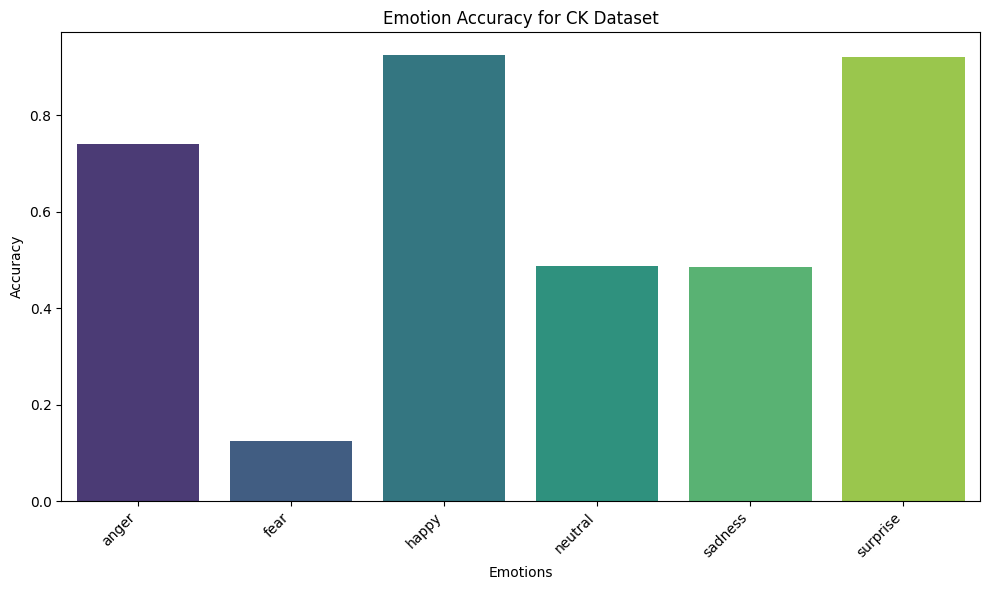

<ipython-input-69-984eea8f78a0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotions, y=accuracy_scores, palette="viridis")


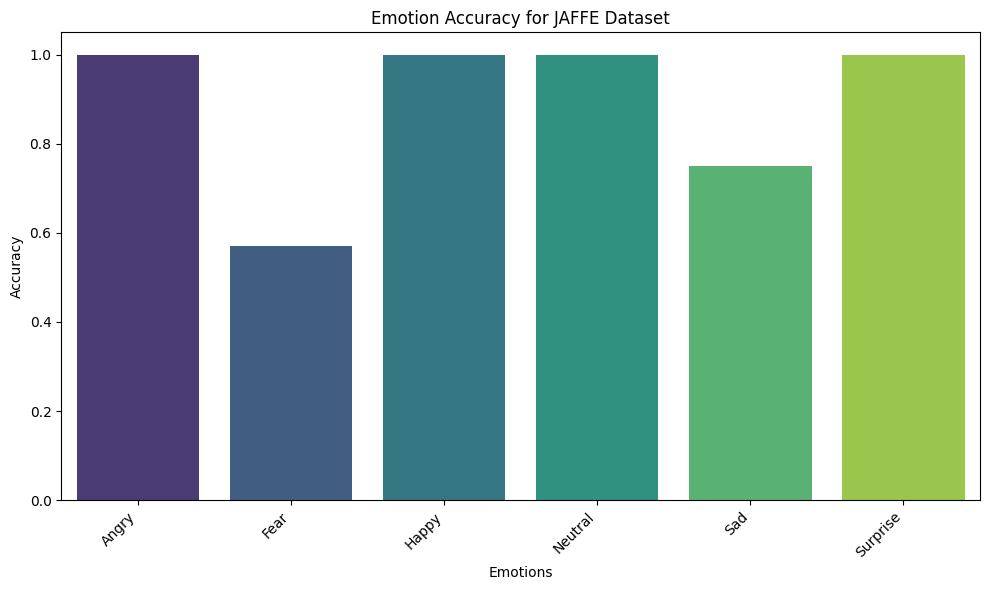

In [ ]:


# Generate classification reports
CK_report = classification_report(CK_y_test, CK_y_pred, output_dict=True)
JAFFE_report = classification_report(JAFFE_y_test, JAFFE_y_pred, output_dict=True)

# Function to plot emotion accuracy for a dataset
def plot_emotion_accuracy(report, dataset_name):
    emotions = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
    accuracy_scores = [report[emotion]['precision'] for emotion in emotions]  # Using 'precision' here, you can change to 'recall' or 'f1-score'

    plt.figure(figsize=(10, 6))
    sns.barplot(x=emotions, y=accuracy_scores, palette="viridis")
    plt.title("Emotion Accuracy for " + dataset_name +" Dataset")
    plt.xlabel("Emotions")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Plot emotion accuracy for CK dataset
plot_emotion_accuracy(CK_report, "CK")

# Plot emotion accuracy for JAFFE dataset
plot_emotion_accuracy(JAFFE_report, "JAFFE")

CK dataset prediction


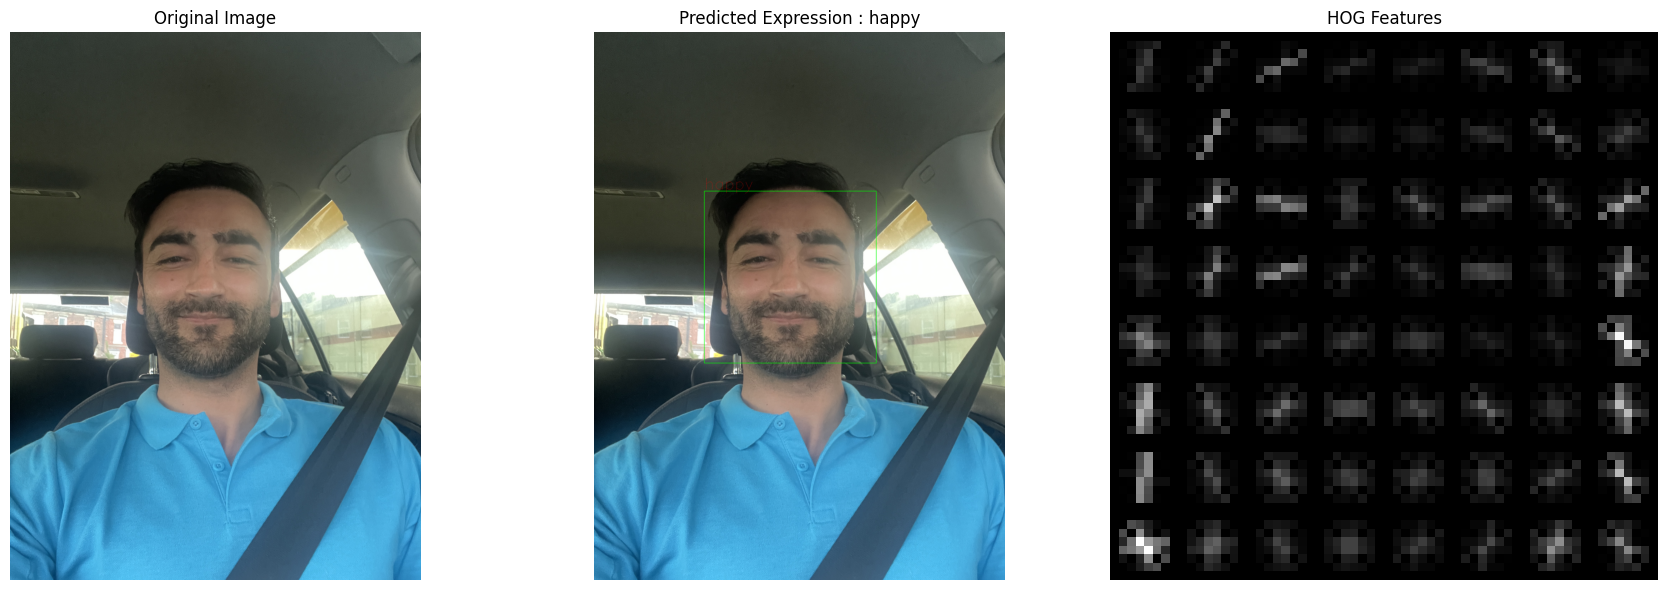

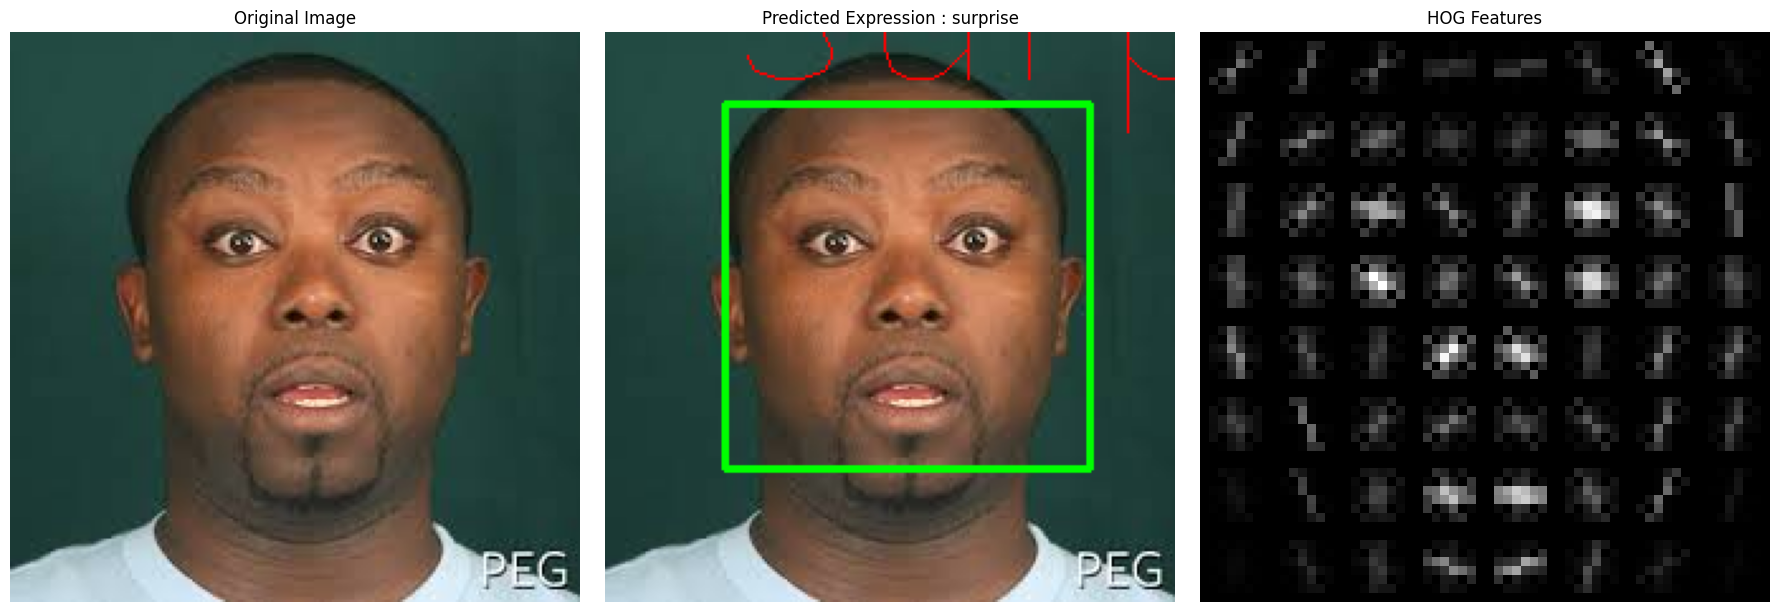

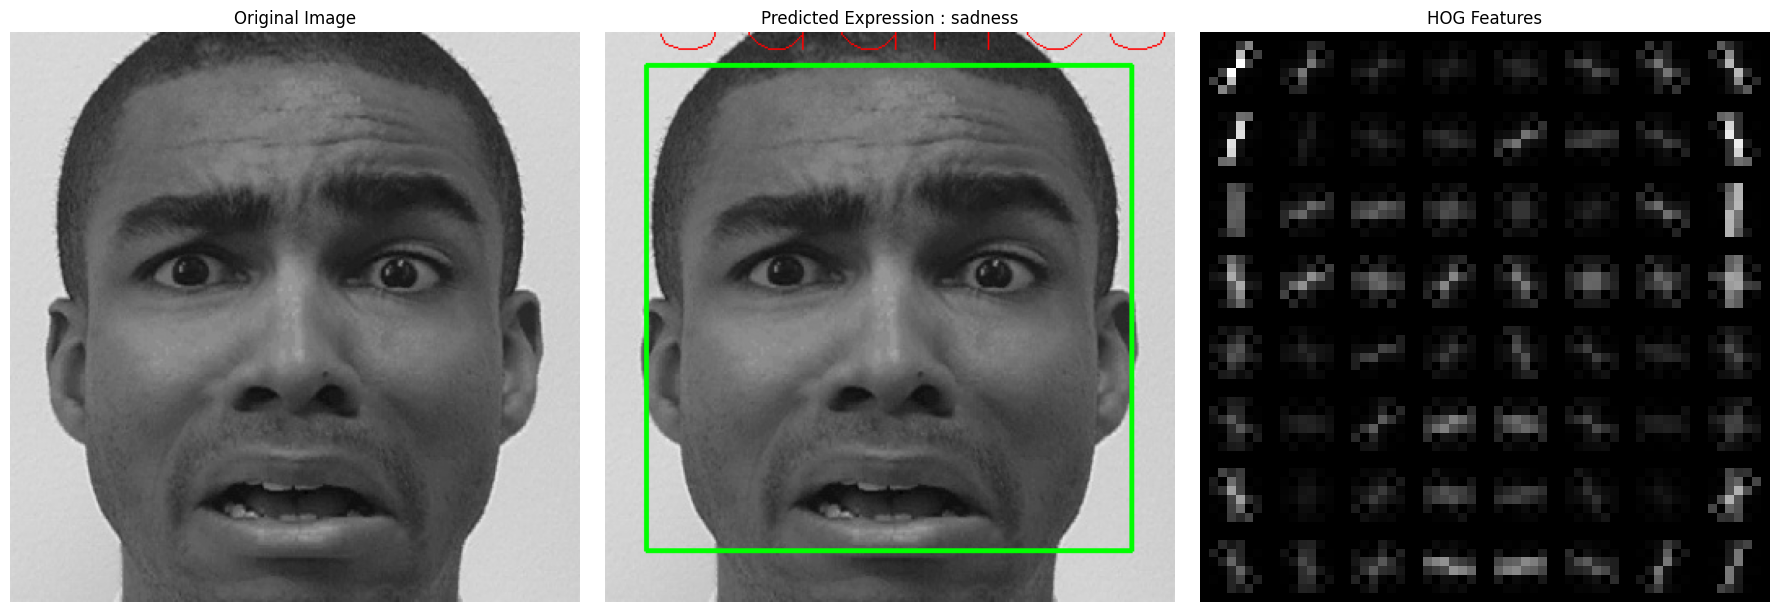

JAFFE dataset Prediction


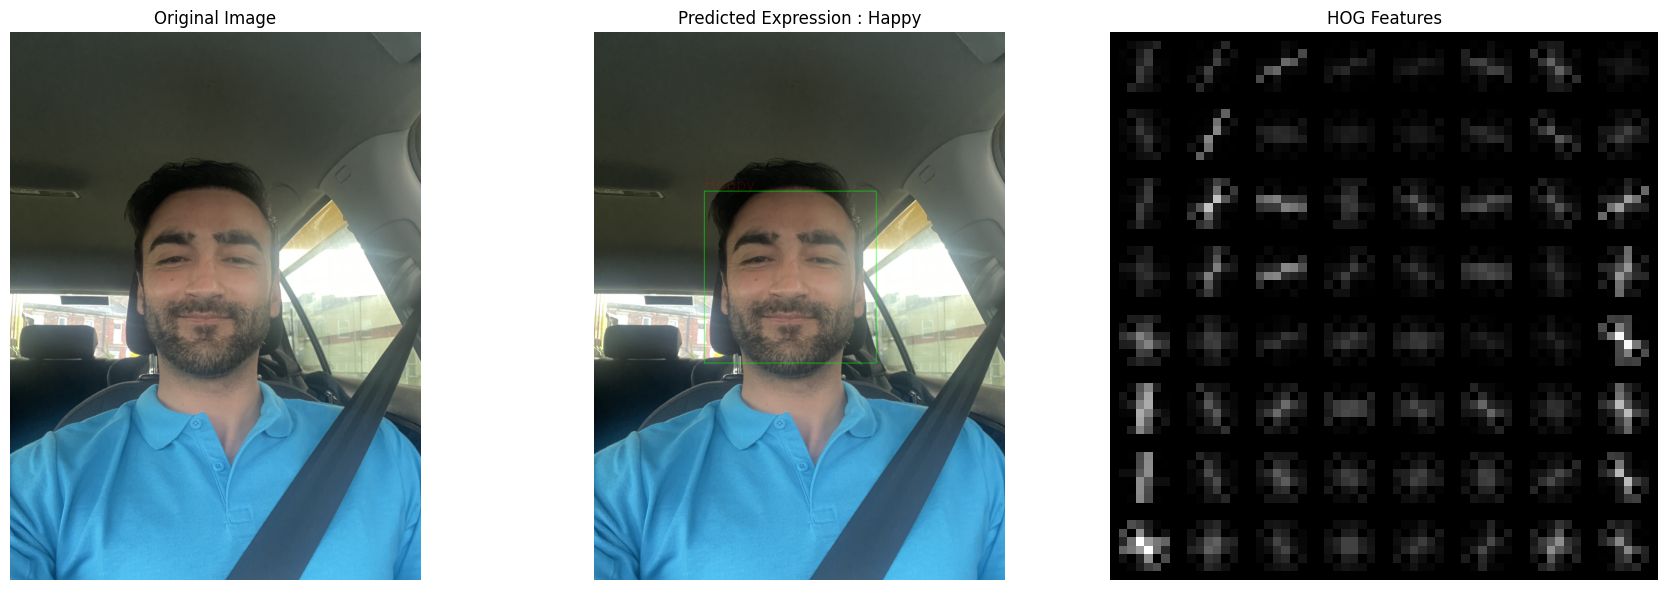

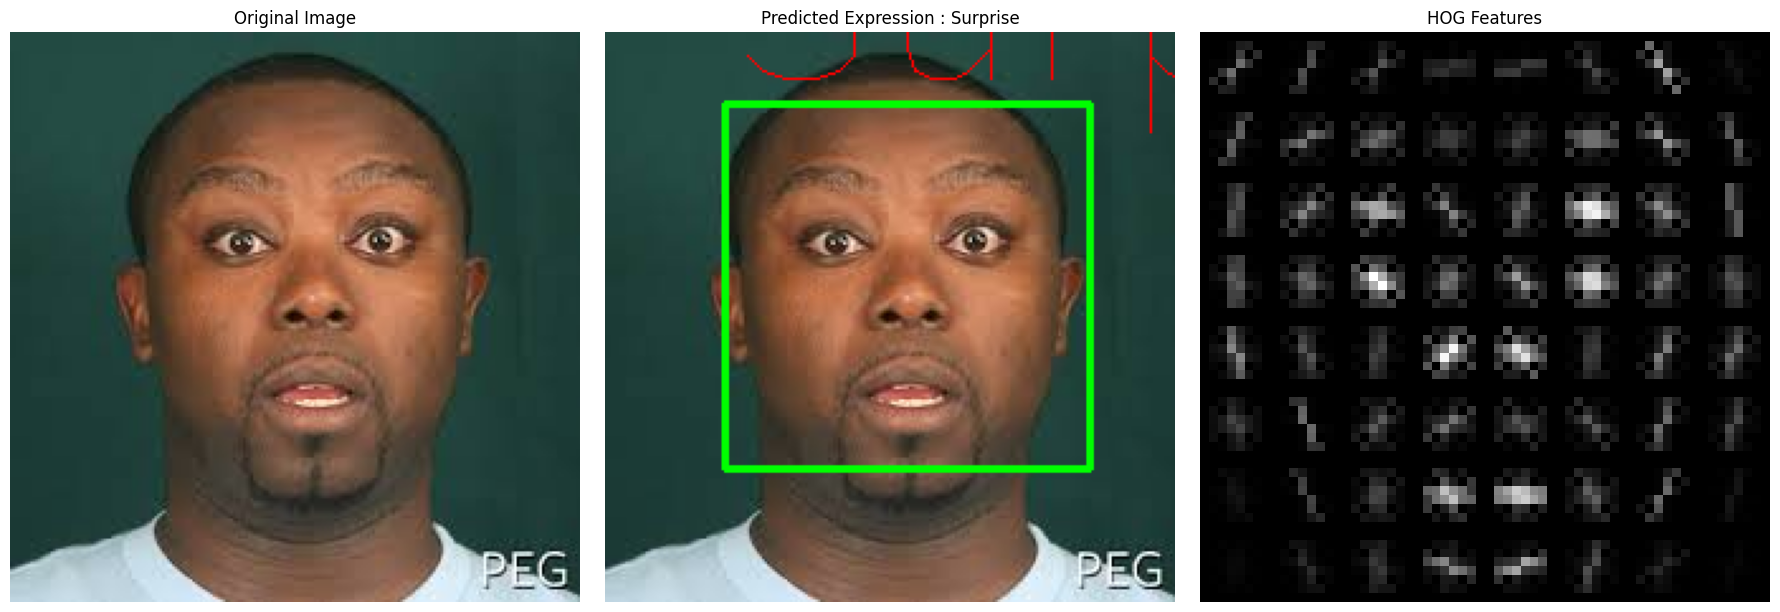

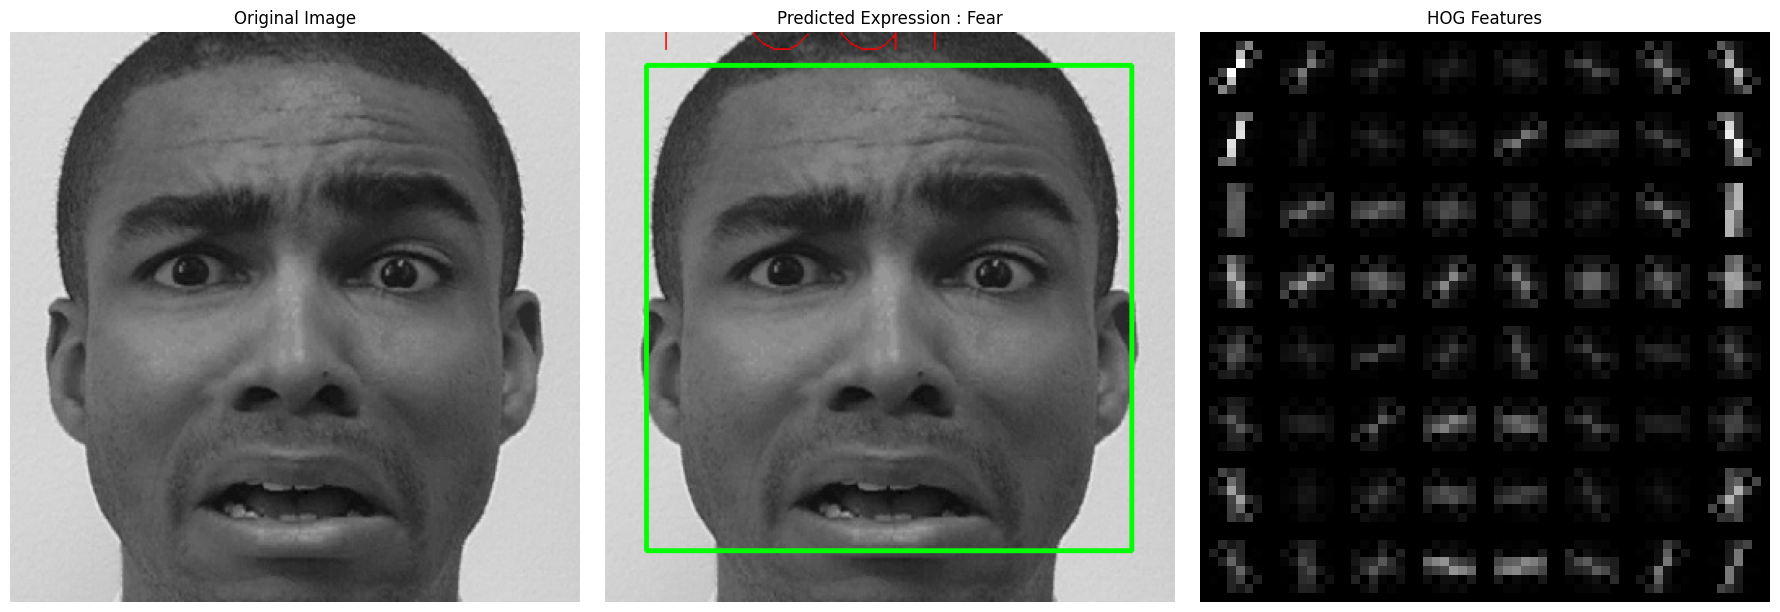

In [ ]:
#Single Image testing (3 images used to test emotions)

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

#Load the Haar Cascade Classifier
face_cascade = cv2.CascadeClassifier("/content/drive/My Drive/haarcascade_frontalface_default.xml")

def extract_hog_features2(image):
    #Resize image
    image = cv2.resize(image, (64, 64))

    hog_features, hog_image = hog( image, orientations=8, pixels_per_cell=(8,8), cells_per_block=(2,2), block_norm=('L2-Hys'), visualize=True)
    return hog_features, hog_image


#FUnction to preprocess extract Hog features amd predict emotion
def predict_emotion(image_path, svm_classifier):

  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  if img is None:
    raise ValueError("Image not found")


  faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
  if len(faces) == 0:
    raise ValueError("No faces detected in the image")

  #Assume first detected face
  (x, y, w, h) = faces[0]
  face_region = img[y:y+h, x:x+w]

  #Extract HOG Features
  features, hog_image = extract_hog_features2(face_region)

  #Features reshape
  features = features.reshape(1, -1)

  #Predict emotion
  predicted_expression = svm_classifier.predict(features)[0]


  #Load the original image
  img_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

  img_with_box = img_rgb.copy()
  cv2.rectangle(img_with_box, (x, y), (x+w, y+h), (0, 255, 0), 2)
  cv2.putText(img_with_box, predicted_expression, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,0,0))

  #Display 3 subplots: PREDICTION , FACE WITH BOUNDING BOX, HOG FEATURES
  plt.figure(figsize=(18, 6))

  #Plot 1 Original image
  plt.subplot(1, 3, 1)
  plt.imshow(img_rgb)
  plt.title("Original Image")
  plt.axis("off")

  #Plot 2 Face with Bounding Box
  plt.subplot(1, 3, 2)
  plt.imshow(img_with_box)
  plt.title("Predicted Expression : " + predicted_expression)
  plt.axis("off")

  #Plot 3 HOG Features
  plt.subplot(1, 3, 3)
  plt.imshow(hog_image, cmap='gray')
  plt.title("HOG Features")
  plt.axis("off")

  plt.tight_layout()
  plt.show()

#3 emptions path
image_path_happy = "/content/drive/My Drive/test1.JPG"
image_path_sad = "/content/drive/My Drive/test6.jpg"
image_path_fear = "/content/drive/My Drive/test7-fear.jpg"

#Predicting from the CK trained model
print("CK dataset prediction")
predict_emotion(image_path_happy, svm_classifier_CK)
predict_emotion(image_path_sad, svm_classifier_CK)
predict_emotion(image_path_fear, svm_classifier_CK)

#Predicting from the JAFFE trained model
print("JAFFE dataset Prediction")
predict_emotion(image_path_happy, svm_classifier_JAFFE)
predict_emotion(image_path_sad, svm_classifier_JAFFE)
predict_emotion(image_path_fear, svm_classifier_JAFFE)